# Code Swim

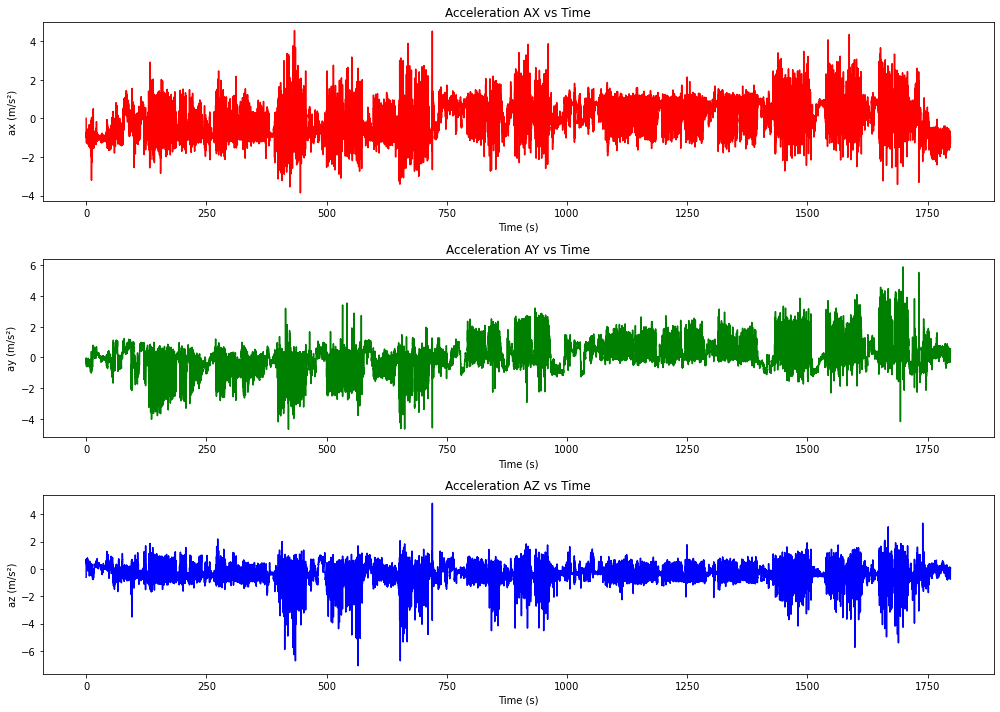

In [12]:
# ----------------------------------------------------------
# Read the CSV file (without headers)
# ----------------------------------------------------------
df = pd.read_csv("/Users/saoudastandard/Downloads/HAH913-2025-PROJETNATATION-main-2/Data/data_swim.csv", header=None)
# ----------------------------------------------------------
# Name the columns manually
# ----------------------------------------------------------
df.columns = ["time", "ax", "ay", "az"]

# ----------------------------------------------------------
# Convert the time column into datetime objects
# ----------------------------------------------------------
df["time"] = pd.to_datetime(df["time"])

# ----------------------------------------------------------
# Convert time into seconds starting from zero
# ----------------------------------------------------------
t = (df["time"] - df["time"].iloc[0]).dt.total_seconds()

# ----------------------------------------------------------
# Create a figure with 3 stacked subplots (one per axis)
# ----------------------------------------------------------
plt.figure(figsize=(14, 10))

# ----------------------------------------------------------
# Subplot 1 : AX vs time
# ----------------------------------------------------------
plt.subplot(3, 1, 1)        # 3 rows, 1 column, subplot index 1
plt.plot(t, df["ax"], color="red")
plt.title("Acceleration AX vs Time")
plt.xlabel("Time (s)")
plt.ylabel("ax (m/s²)")

# ----------------------------------------------------------
# Subplot 2 : AY vs time
# ----------------------------------------------------------
plt.subplot(3, 1, 2)        # subplot index 2
plt.plot(t, df["ay"], color="green")
plt.title("Acceleration AY vs Time")
plt.xlabel("Time (s)")
plt.ylabel("ay (m/s²)")

# ----------------------------------------------------------
# Subplot 3 : AZ vs time
# ----------------------------------------------------------
plt.subplot(3, 1, 3)        # subplot index 3
plt.plot(t, df["az"], color="blue")
plt.title("Acceleration AZ vs Time")
plt.xlabel("Time (s)")
plt.ylabel("az (m/s²)")

# ----------------------------------------------------------
# Adjust spacing between subplots to avoid overlap
# ----------------------------------------------------------
plt.tight_layout()

# ----------------------------------------------------------
# Display the figure
# ----------------------------------------------------------
plt.show()


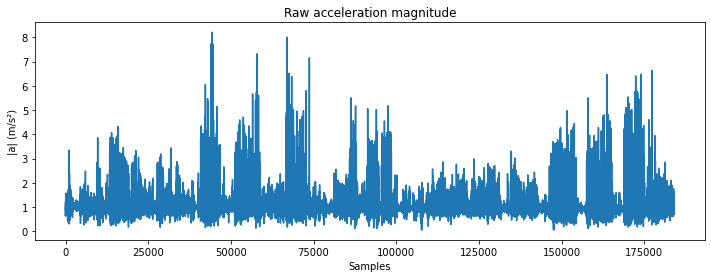

In [13]:
# ----------------------------------------------------------
# Compute the magnitude (norm) of the raw acceleration vector
# norm = sqrt(ax² + ay² + az²)
# ----------------------------------------------------------

df["norm"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

# ----------------------------------------------------------
# Plot the raw acceleration magnitude to inspect the signal
# ----------------------------------------------------------

plt.figure(figsize=(12,4))
plt.plot(df["norm"])
plt.title("Raw acceleration magnitude")
plt.xlabel("Samples")
plt.ylabel("|a| (m/s²)")
plt.show()


Estimated sampling frequency fs = 100.00000000009095 Hz


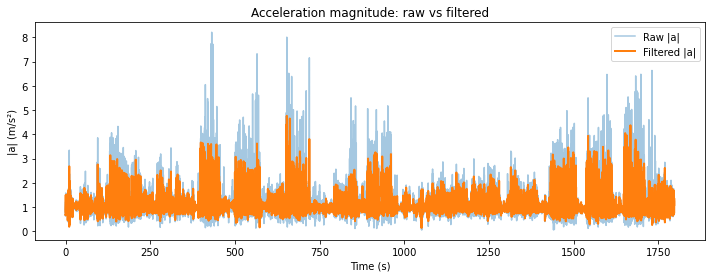

Number of detected peaks: 1042


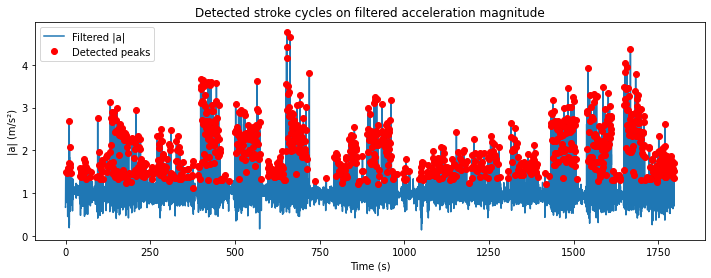

Mean cycle frequency (Hz): 0.579720152765449
SD of inter-peak intervals (s): 2.7281750625690946
CV of inter-peak intervals: 1.5815780640434438
Mean peak amplitude (m/s²): 2.0182638069090175


,style,allure,freq_cycle_hz,SD_T,CV_T,amp_moyenne
0,crawl,modere,0.57972,2.728175,1.581578,2.018264


In [14]:
# ================================
# 1. IMPORT LIBRARIES
# ================================

# Import pandas for reading CSV files and manipulating tabular data
import pandas as pd

# Import numpy for numerical operations (arrays, sqrt, mean, std, etc.)
import numpy as np

# Import matplotlib for plotting figures
import matplotlib.pyplot as plt

# Import signal processing tools (for filtering and peak detection)
from scipy.signal import butter, filtfilt, find_peaks


# ================================
# 2. READ THE RAW CSV FILE
# ================================

# Read the CSV file containing the swimming data
# header=None is used because the file does NOT contain column names in the first row
df = pd.read_csv("/Users/saoudastandard/Downloads/HAH913-2025-PROJETNATATION-main-2/Data/data_swim.csv", header=None)


# ================================
# 3. NAME THE COLUMNS
# ================================

# Manually assign meaningful column names to the dataframe
# The file has 4 columns: time stamp, ax, ay, az
df.columns = ["time", "ax", "ay", "az"]


# ================================
# 4. CONVERT TIME TO SECONDS
# ================================

# Convert the "time" column from text/string to pandas datetime format
df["time"] = pd.to_datetime(df["time"])

# Create a new array "t" containing time in seconds relative to the first sample
# (time[0] = 0, time[1] = Δt, etc.)
t = (df["time"] - df["time"].iloc[0]).dt.total_seconds().values


# ================================
# 5. ESTIMATE THE SAMPLING FREQUENCY fs
# ================================

# Compute the time differences between consecutive samples
dt = np.diff(t)

# Estimate the sampling period as the median of dt (robust to small jitter)
Ts = np.median(dt)

# Compute the sampling frequency fs = 1 / Ts
fs = 1.0 / Ts

# Print fs to check that it makes sense (e.g., around 100 Hz)
print("Estimated sampling frequency fs =", fs, "Hz")


# ================================
# 6. COMPUTE THE ACCELERATION MAGNITUDE (NORM)
# ================================

# Compute the norm of the acceleration vector: sqrt(ax^2 + ay^2 + az^2)
df["a_norm"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)


# ================================
# 7. DEFINE A LOW-PASS FILTER FUNCTION
# ================================

# Define a function that applies a Butterworth low-pass filter using filtfilt
def lowpass_filter(signal, fs, cutoff=5.0, order=4):
    """
    Apply a low-pass Butterworth filter to a 1D signal.

    signal : array-like, input signal
    fs     : sampling frequency (Hz)
    cutoff : cutoff frequency of the low-pass filter (Hz)
    order  : order of the Butterworth filter
    """
    # Compute the Nyquist frequency (half the sampling frequency)
    nyq = 0.5 * fs

    # Normalize the cutoff frequency with respect to the Nyquist frequency
    normal_cutoff = cutoff / nyq

    # Design the Butterworth low-pass filter (returns filter coefficients b and a)
    b, a = butter(order, normal_cutoff, btype="low", analog=False)

    # Apply the filter in forward and backward directions to avoid phase shift
    filtered_signal = filtfilt(b, a, signal)

    # Return the filtered signal
    return filtered_signal


# ================================
# 8. FILTER THE ACCELERATION NORM
# ================================

# Apply the low-pass filter to the acceleration magnitude
# You can adjust "cutoff" depending on your data (e.g., 4–6 Hz)
a_filt = lowpass_filter(df["a_norm"].values, fs=fs, cutoff=5.0, order=4)


# ================================
# 9. PLOT RAW VS FILTERED SIGNAL (OPTIONAL)
# ================================

# Create a new figure for plotting raw and filtered magnitude
plt.figure(figsize=(12, 4))

# Plot the raw acceleration magnitude
plt.plot(t, df["a_norm"].values, label="Raw |a|", alpha=0.4)

# Plot the filtered acceleration magnitude
plt.plot(t, a_filt, label="Filtered |a|", linewidth=2)

# Add title and axis labels
plt.title("Acceleration magnitude: raw vs filtered")
plt.xlabel("Time (s)")
plt.ylabel("|a| (m/s²)")

# Add legend
plt.legend()

# Display the figure
plt.show()


# ================================
# 10. DETECT PEAKS (CYCLES) ON FILTERED SIGNAL
# ================================

# Define the minimum expected duration of one stroke cycle in seconds
# Example: 0.5 s → at most 2 cycles per second
min_cycle_duration_s = 0.5

# Convert this minimum duration into samples: distance between two peaks
min_distance_samples = int(min_cycle_duration_s * fs)

# Define a minimum prominence for peaks (adjust to your data)
min_prominence = 0.5  # you may need to tune this value

# Use scipy.signal.find_peaks to detect peaks in the filtered magnitude
peaks, properties = find_peaks(
    a_filt,
    distance=min_distance_samples,
    prominence=min_prominence
)

# Print the number of detected peaks to check
print("Number of detected peaks:", len(peaks))


# ================================
# 11. PLOT FILTERED SIGNAL WITH DETECTED PEAKS
# ================================

# Create a new figure
plt.figure(figsize=(12, 4))

# Plot the filtered signal
plt.plot(t, a_filt, label="Filtered |a|")

# Plot the detected peaks as points
plt.plot(t[peaks], a_filt[peaks], "ro", label="Detected peaks")

# Add labels and title
plt.title("Detected stroke cycles on filtered acceleration magnitude")
plt.xlabel("Time (s)")
plt.ylabel("|a| (m/s²)")

# Show legend
plt.legend()

# Display the plot
plt.show()


# ================================
# 12. COMPUTE CYCLE METRICS (Ti, frequency, SD, CV, amplitude)
# ================================

# Extract the time values at each detected peak
t_peaks = t[peaks]

# Compute inter-peak intervals (Ti) in seconds
Ti = np.diff(t_peaks)

# Compute the mean cycle frequency in Hz: 1 / mean(Ti)
freq_cycle_hz = 1.0 / Ti.mean()

# Compute the standard deviation of the inter-peak intervals
SD_T = Ti.std()

# Compute the coefficient of variation: SD / mean
CV_T = SD_T / Ti.mean()

# Compute the mean peak amplitude of the filtered signal
amp_mean = a_filt[peaks].mean()

# Print the metrics to check the values
print("Mean cycle frequency (Hz):", freq_cycle_hz)
print("SD of inter-peak intervals (s):", SD_T)
print("CV of inter-peak intervals:", CV_T)
print("Mean peak amplitude (m/s²):", amp_mean)


# ================================
# 13. CREATE A ONE-ROW METRICS TABLE FOR THIS CONDITION
# ================================

# Define labels for this condition (edit these according to your file)
style = "crawl"    # e.g., "crawl" or "brasse"
allure = "modere"  # e.g., "modere" or "rapide"

# Create a dictionary with all metrics for this condition
metrics_row = {
    "style": style,
    "allure": allure,
    "freq_cycle_hz": freq_cycle_hz,
    "SD_T": SD_T,
    "CV_T": CV_T,
    "amp_moyenne": amp_mean
}

# Convert the dictionary to a one-row pandas DataFrame
df_metrics = pd.DataFrame([metrics_row])

# Display the metrics table
df_metrics

